## 라이브러리

In [1]:
## 레이어
from keras.layers import Input, Lambda, Dense, Flatten

## 모델
from keras.models import Model

# VGG 
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.models import model_from_json
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [2]:
# resize image
IMAGE_SIZE =[224,224]
train_path = 'trafficnet_dataset_v1/train'
valid_path = 'trafficnet_dataset_v1/test'

# 전이학습 모델 생성

In [3]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights = 'imagenet',include_top=False)

In [4]:
# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

## 이미지 파일 경로 설정

In [5]:
# useful for getting number of classes
folders = glob('trafficnet_dataset_v1/train/*')

In [6]:
folders

['trafficnet_dataset_v1/train/accident',
 'trafficnet_dataset_v1/train/sparse_traffic',
 'trafficnet_dataset_v1/train/dense_traffic',
 'trafficnet_dataset_v1/train/fire']

In [7]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)

In [8]:
len(folders)

4

## 클래스 예측

In [9]:
# 각 folder 클래스 예측.ex) 사고, 원할한 차 통행, 원할하지 않은 통행, 화재
prediction = Dense(len(folders), activation='softmax')(x)

## 모델 구성 확인

In [10]:
# 모델 객체 생성
model = Model(inputs=vgg.input, outputs = prediction)
vgg16_model_obejct = model

In [11]:
# vgg16 모델 설명
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## 모델 시각화

In [12]:
import keras.utils

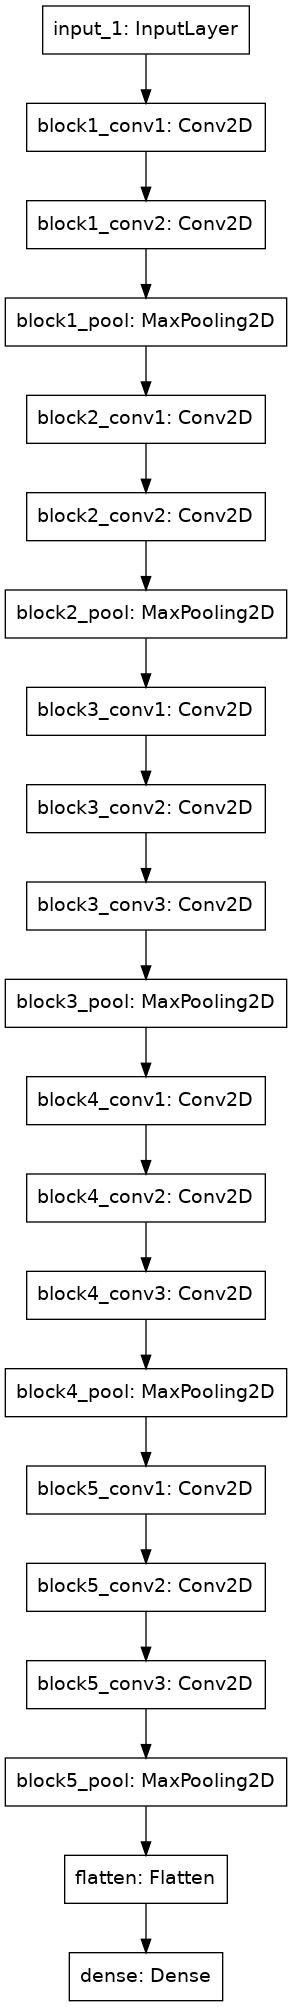

In [13]:
keras.utils.plot_model(model)

## 모델 컴파일

In [14]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics=['accuracy']
)

## 데이터 스케일링

In [15]:
from keras.preprocessing.image import ImageDataGenerator

In [16]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True)

In [17]:
test_datagen = ImageDataGenerator(rescale = 1./255)

In [18]:
# class set
training_set = train_datagen.flow_from_directory('trafficnet_dataset_v1/train',
                                                 target_size = (224,224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 3600 images belonging to 4 classes.


In [19]:
# class set
test_set = test_datagen.flow_from_directory('trafficnet_dataset_v1/test',
                                                 target_size = (224,224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 800 images belonging to 4 classes.


## early stopping

In [20]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [21]:
epochs_to_wait_improve=10
model_name = 'model/trafficfeatures_vgg16_model.h5'
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience=epochs_to_wait_improve)
checkpoint_callback = ModelCheckpoint(model_name, monitor='val_loss',verbose=1, save_best_only=True,mode='min')

## 학습

In [22]:
r = model.fit_generator(
    training_set,
    validation_data = test_set,
    epochs=50,
    steps_per_epoch=len(training_set),
    validation_steps=len(test_set),
    callbacks=[early_stopping_callback, checkpoint_callback]
)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
113/113 [==============================] - 37s 287ms/step - loss: 1.0024 - accuracy: 0.6309 - val_loss: 0.4712 - val_accuracy: 0.8175

Epoch 00001: val_loss improved from inf to 0.47125, saving model to model/trafficfeatures_vgg16_model.h5
Epoch 2/50
113/113 [==============================] - 31s 274ms/step - loss: 0.3542 - accuracy: 0.8760 - val_loss: 0.3986 - val_accuracy: 0.8562

Epoch 00002: val_loss improved from 0.47125 to 0.39858, saving model to model/trafficfeatures_vgg16_model.h5
Epoch 3/50
113/113 [==============================] - 31s 274ms/step - loss: 0.2815 - accuracy: 0.8983 - val_loss: 0.3636 - val_accuracy: 0.8575

Epoch 00003: val_loss improved from 0.39858 to 0.36357, saving model to model/trafficfeatures_vgg16_model.h5
Epoch 4/50
113/113 [==============================] - 31s 275ms/step - loss: 0.1920 - accuracy: 0.9302 - val_loss: 0.4442 - val_accuracy: 0.8500

Epoch 00004: val_loss did not improve from 0.36357
Epoch 5/50
113/113 [======================

## 시각화

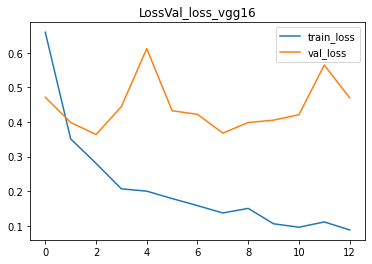

In [23]:
# loss
plt.title('LossVal_loss_vgg16')
plt.plot(r.history['loss'],label = 'train_loss')
plt.plot(r.history['val_loss'],label = 'val_loss')
plt.legend()
plt.savefig('LossVal_loss_vgg16')

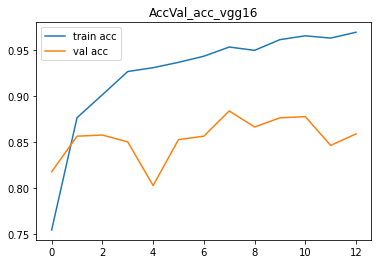

In [24]:
# accuracies
plt.title('AccVal_acc_vgg16')
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.savefig('AccVal_acc_vgg16')

## 예측

In [1]:
import tensorflow as tf

In [2]:
model.save('model/trafficfeatures_vgg16_model.h5')

NameError: name 'model' is not defined

In [3]:
model.save_weights("weights/trafficfeatures_vgg_16_model_weights.h5")

NameError: name 'model' is not defined

# 모델 불러오기

In [5]:
import tensorflow as tf

In [6]:
from IPython.display import Image  # 주피터 노트북에 이미지 삽입

In [7]:
import tensorflow as tf
import cv2
from tensorflow.python.keras.preprocessing.image import img_to_array
from keras.applications.inception_v3 import preprocess_input
from IPython.display import Image  # 주피터 노트북에 이미지 삽입

In [8]:
def run_predict(file_path):
    image = cv2.imread(file_path)
    image = cv2.resize(image,dsize=(224,224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0],image.shape[1],image.shape[2]))
    image = preprocess_input(image)
    yhat = model.predict(image)
    print("accident_accuray : ",yhat[0][0])
    print("dense_traffic_accuray : ",yhat[0][1])
    print("fire_accuray : ",yhat[0][2])
    print("sparse_traffic_accuray : ",yhat[0][3])

In [9]:
# model_load
model = tf.keras.models.load_model('model/trafficfeatures_vgg16_model.h5', compile=False)

In [ ]:
# vgg16_model_obejct # model object

accident_accuray :  0.99600273
dense_traffic_accuray :  9.348529e-06
fire_accuray :  0.0008279972
sparse_traffic_accuray :  0.0031598685


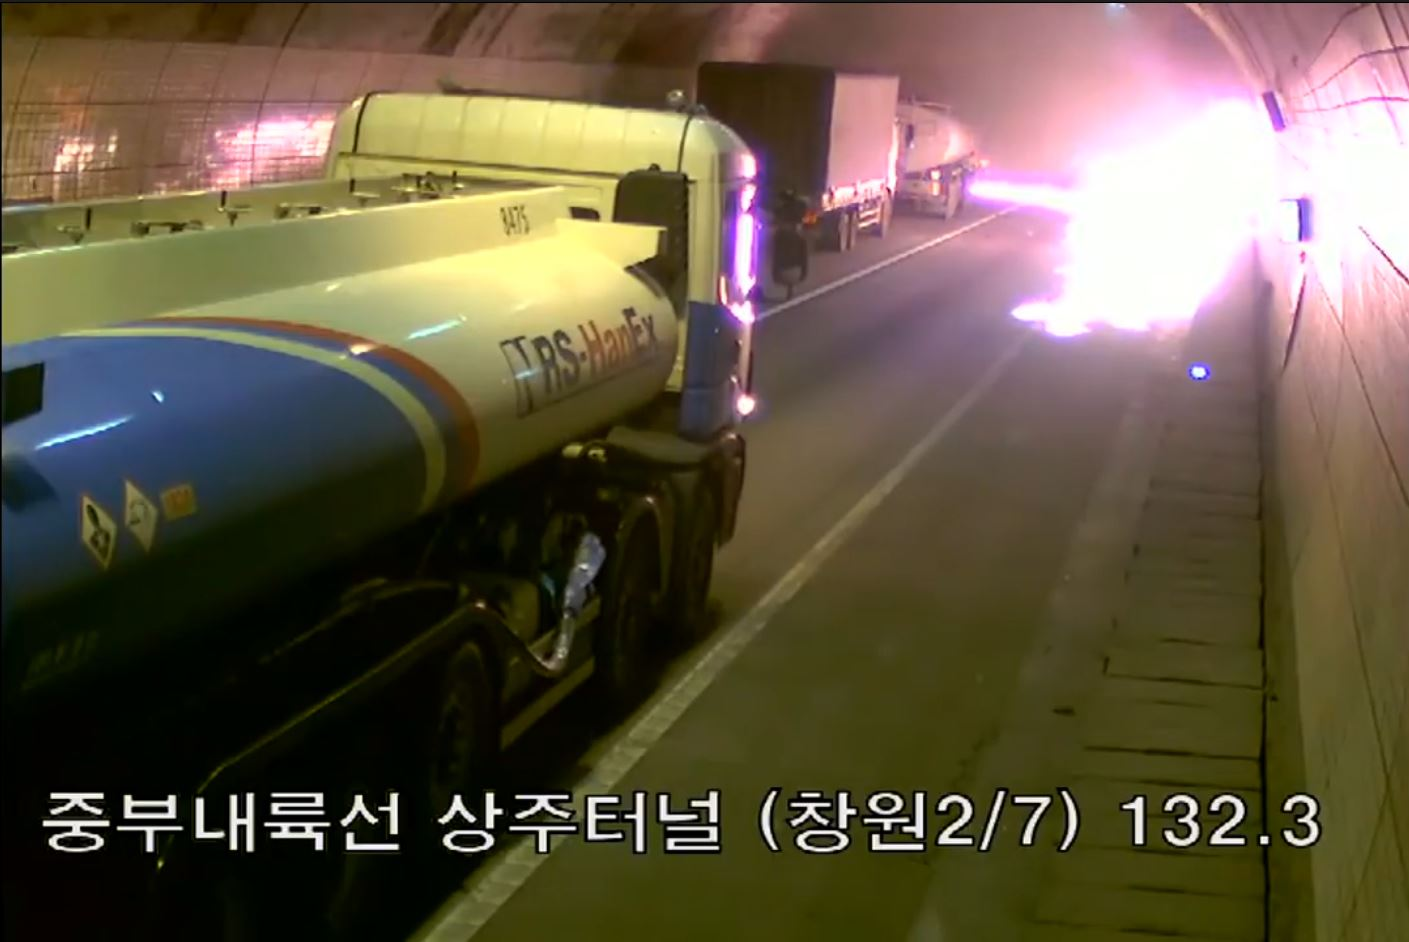

In [12]:
file_path = 'images/test1.JPG'
run_predict(file_path)
Image(file_path)

accident_accuray :  0.006163912
dense_traffic_accuray :  0.0012847438
fire_accuray :  0.9908544
sparse_traffic_accuray :  0.0016968874


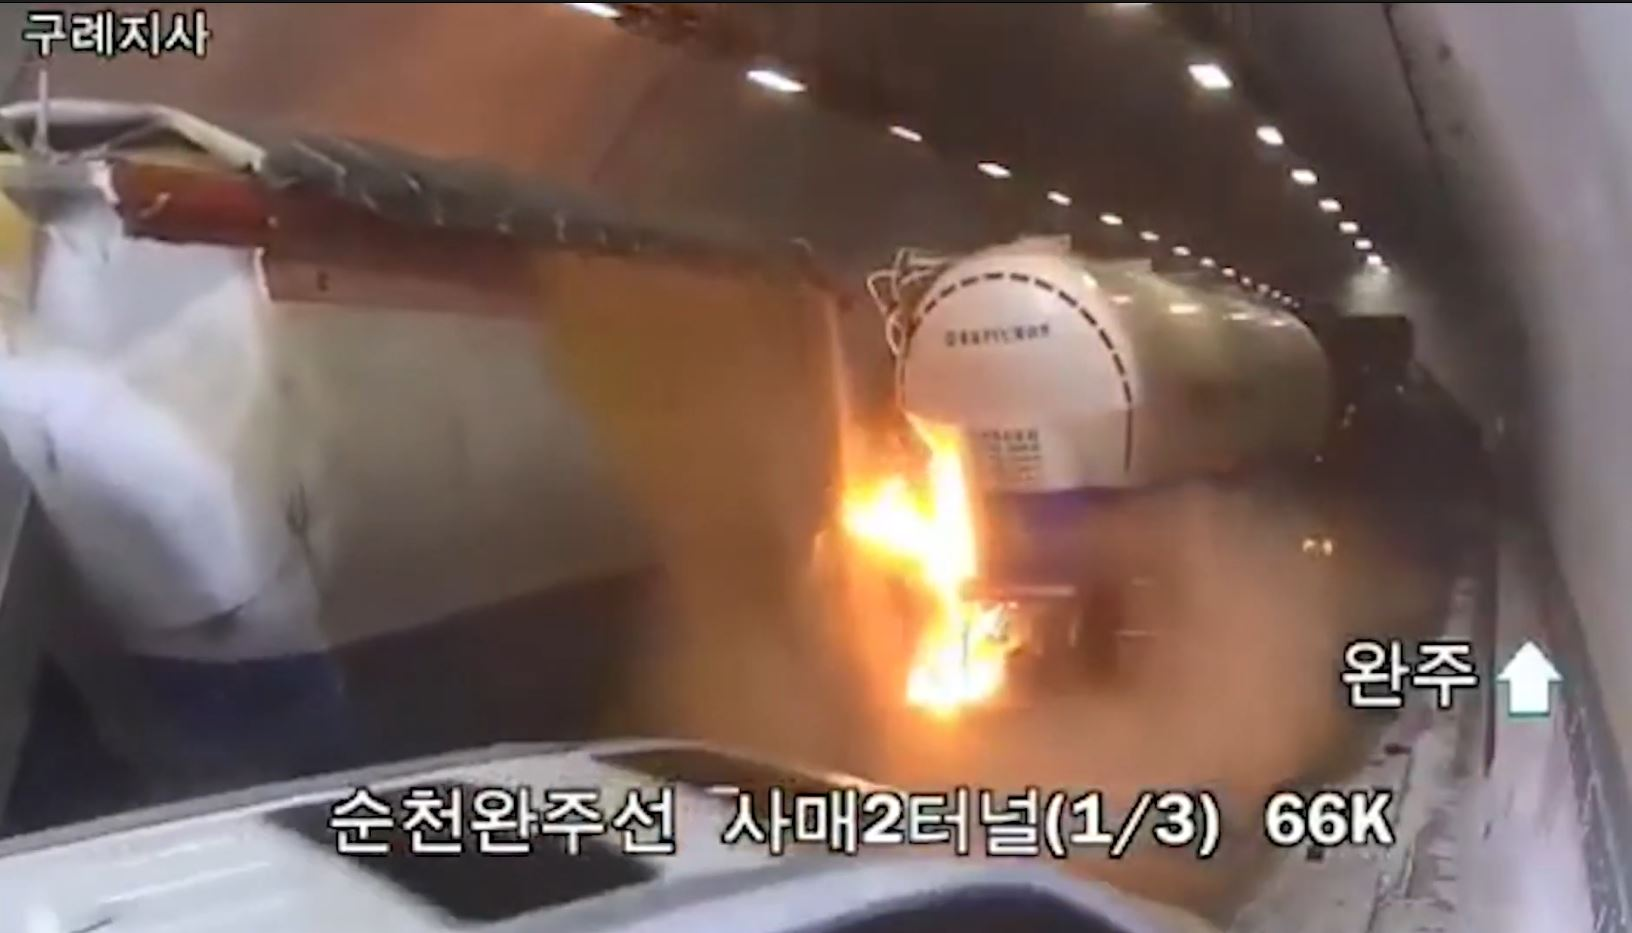

In [13]:
file_path = 'images/test2.JPG'
run_predict(file_path)
Image(file_path)

accident_accuray :  0.0019707172
dense_traffic_accuray :  0.0008921295
fire_accuray :  3.6286688e-06
sparse_traffic_accuray :  0.9971335


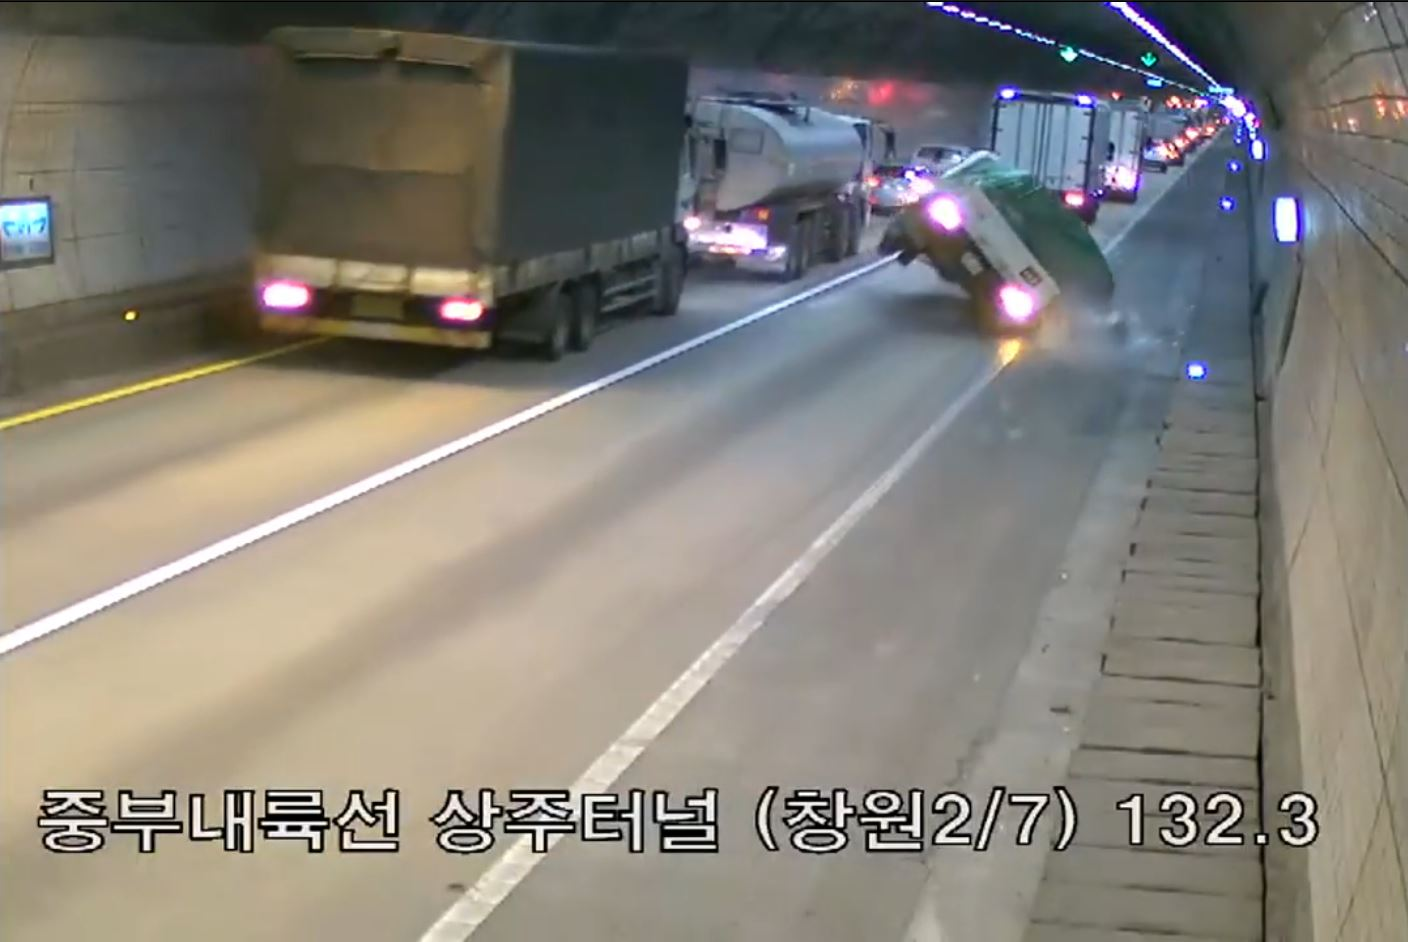

In [14]:
file_path = 'images/test3.JPG'
run_predict(file_path)
Image(file_path)

accident_accuray :  0.00015839077
dense_traffic_accuray :  0.0006729673
fire_accuray :  7.2149527e-07
sparse_traffic_accuray :  0.9991679


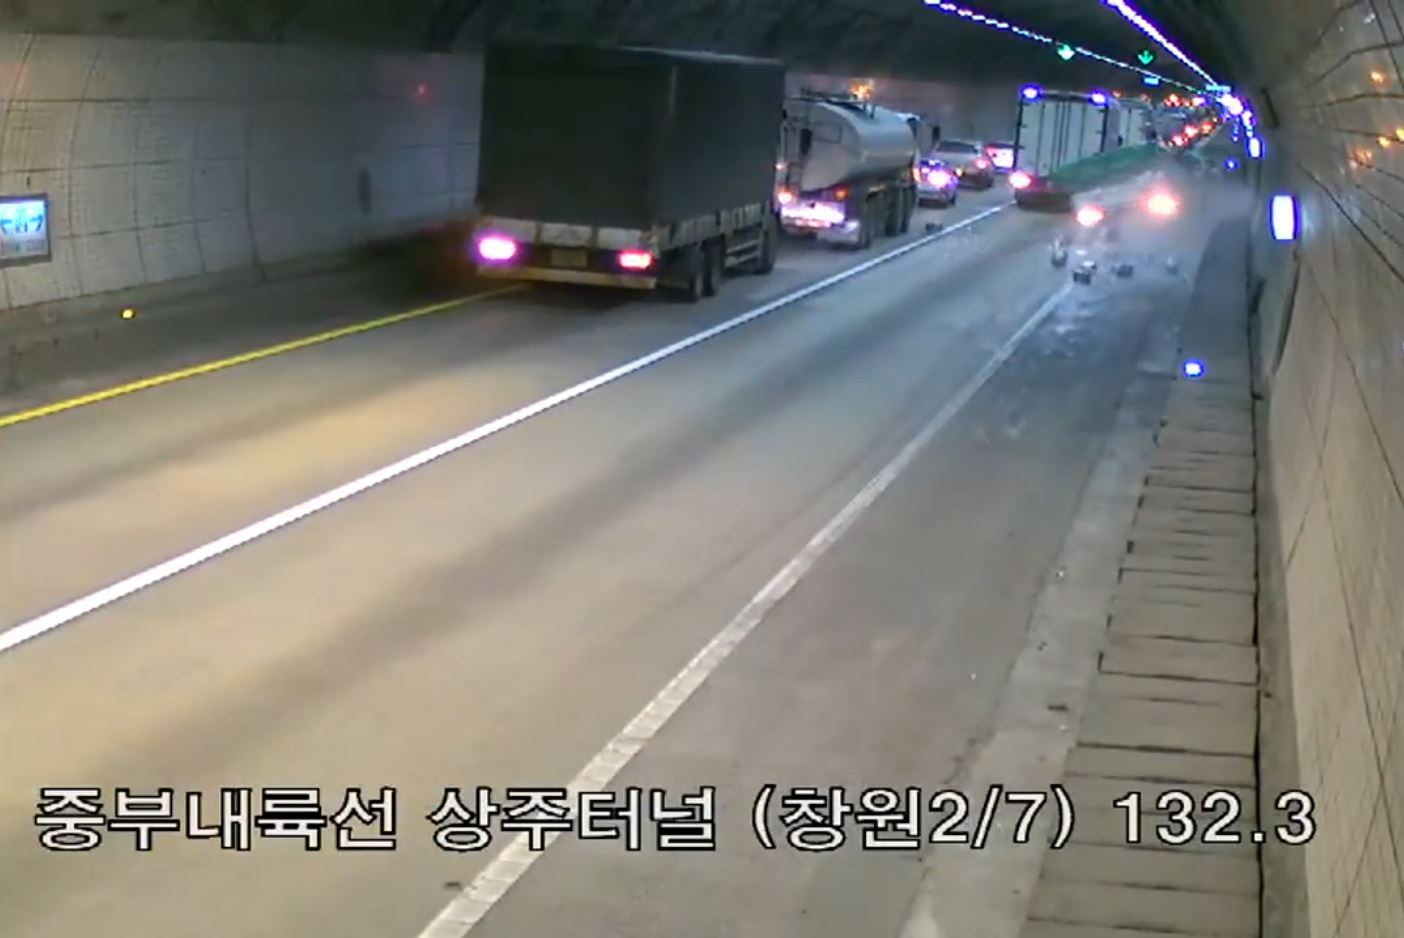

In [15]:
file_path = 'images/test4.JPG'
run_predict(file_path)
Image(file_path)

accident_accuray :  0.07198492
dense_traffic_accuray :  0.00037441336
fire_accuray :  0.9276148
sparse_traffic_accuray :  2.5837462e-05


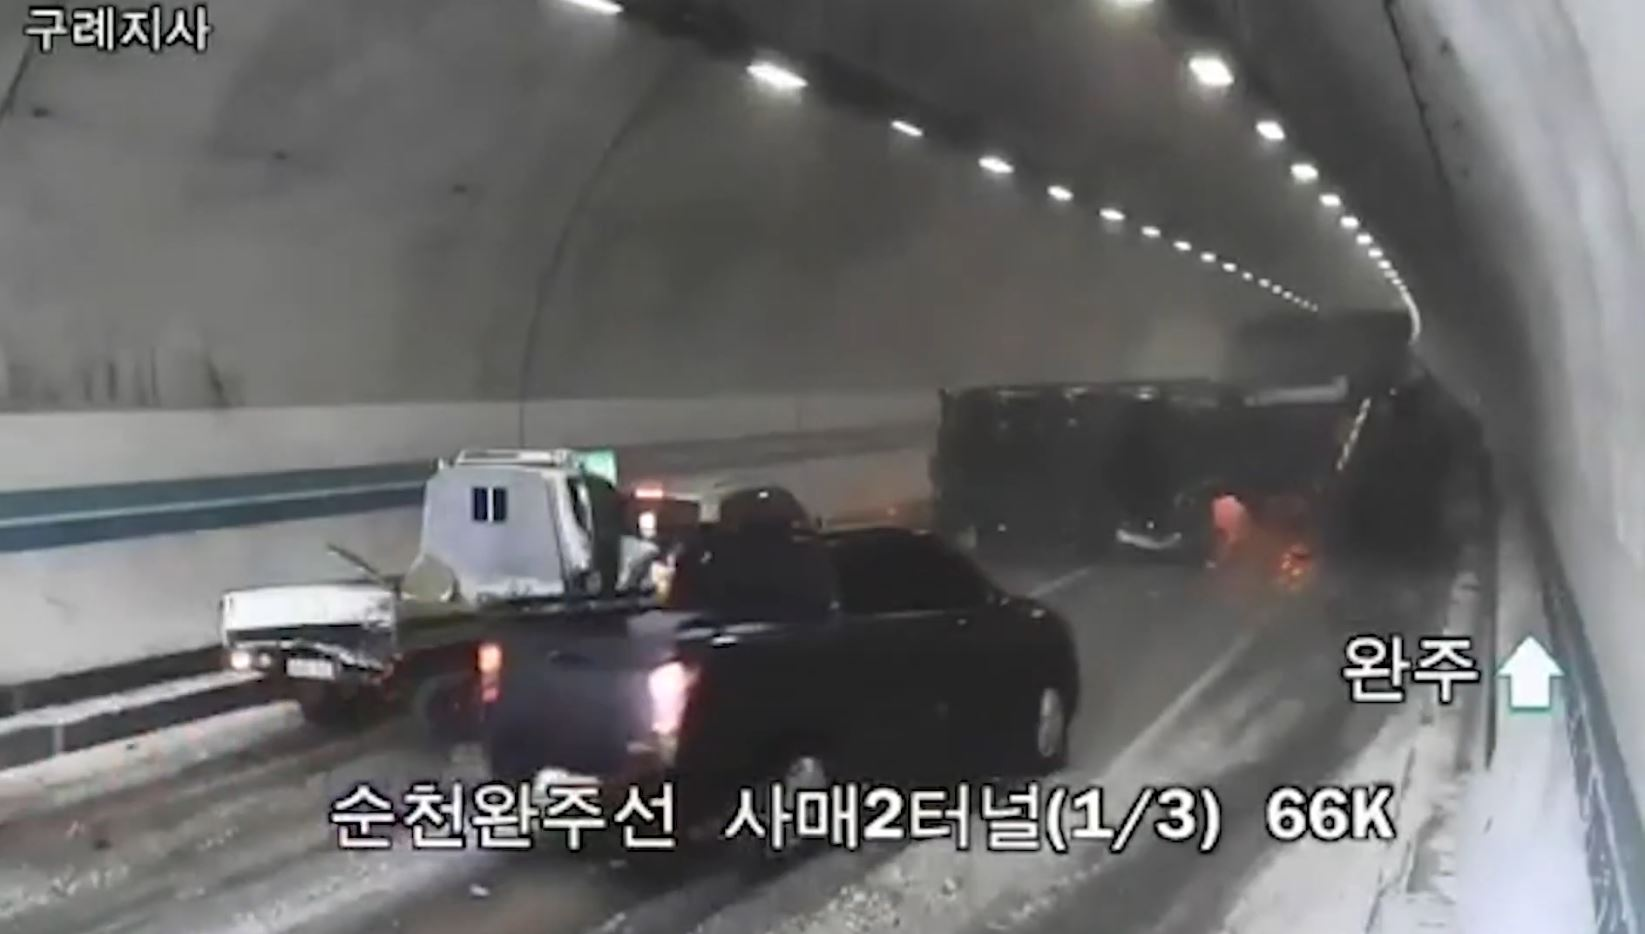

In [16]:
file_path = 'images/test5.JPG'
run_predict(file_path)
Image(file_path)

accident_accuray :  0.9999999
dense_traffic_accuray :  2.084878e-08
fire_accuray :  4.7940665e-11
sparse_traffic_accuray :  7.540742e-08


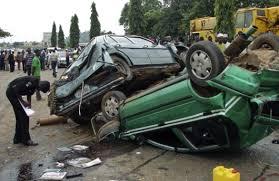

In [17]:
file_path = 'trafficnet_dataset_v1/test/accident/images_078 (2).jpg'
run_predict(file_path)
Image(file_path)

accident_accuray :  4.79903e-09
dense_traffic_accuray :  0.999998
fire_accuray :  2.3457247e-11
sparse_traffic_accuray :  2.050712e-06


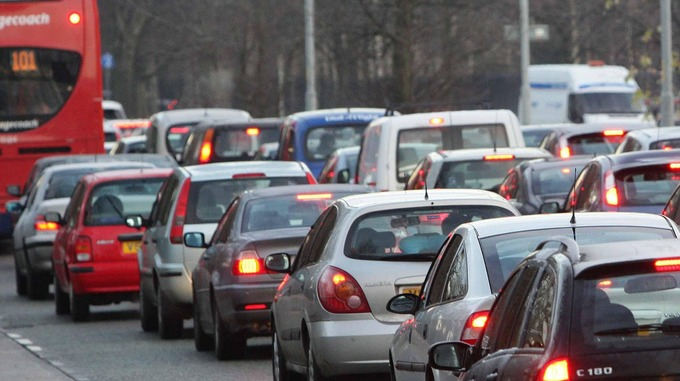

In [18]:
file_path = 'images/2.jpg'
run_predict(file_path)
Image("images/2.jpg")

accident_accuray :  3.060259e-05
dense_traffic_accuray :  4.718642e-05
fire_accuray :  1.7176727e-11
sparse_traffic_accuray :  0.99992216


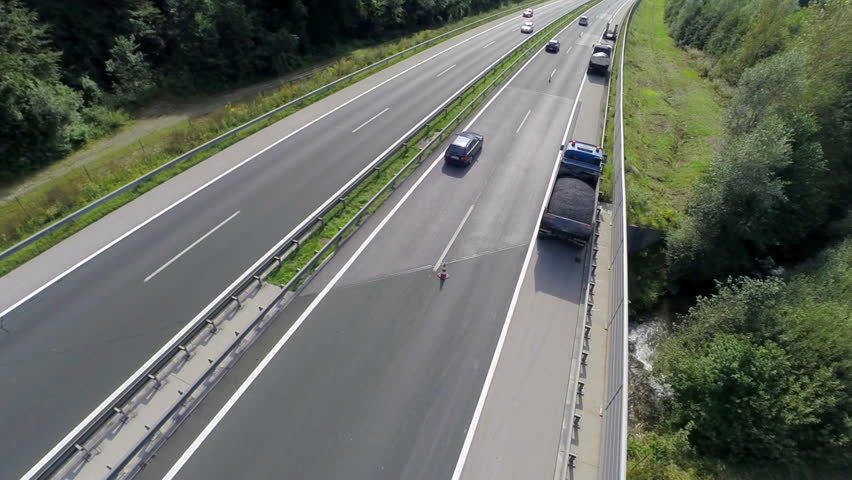

In [19]:
file_path = 'images/1.jpg'
run_predict(file_path)
Image("images/1.jpg")

accident_accuray :  4.680762e-06
dense_traffic_accuray :  2.2644215e-07
fire_accuray :  0.99995923
sparse_traffic_accuray :  3.587607e-05


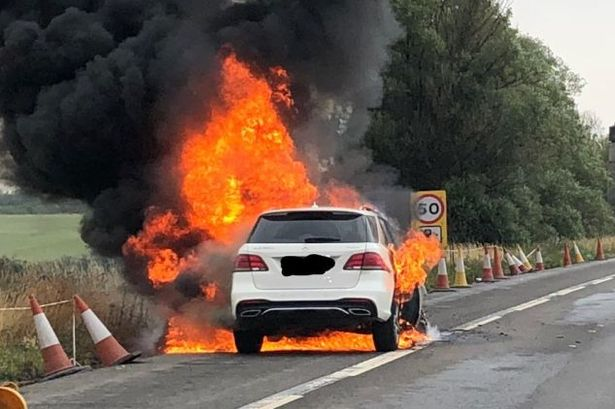

In [20]:
file_path = 'images/4.jpg'
run_predict(file_path)
Image("images/4.jpg")